# Customer review timeline (of Sea Temple Port Douglas)

## TLDR:

I explore the current trends of `customer experience` through online comments on TripAdvisor for Pullman Sea temple (PPD) in Port Douglas, Queensland, Australia.

By analysing the scores, I discovered:
- The [score distribution by comments](#how-scores-distribute). Most comments have a high score (5 bubbles/stars)!

However, when applying a `Time series analysis` I realised that:
1. [Monthly average number of comments](#timeseries) has increased through the years, although
2. [Score evolution](#score-through-time) shows a declining trend in recent years, and
3. when counting the proportion of comments, I discovered that despite most comments are still positive, negatives are more predominant
4. When checking the absolute values we see negative comments remaining the same but there are fewer new positive comments

To understand the customer experience and why the score is declining, I performed several `Text analysis` of the actual comments, to discover:
1. By using multiple strategies I extracted [most common phases](#the-comments) to see which factors are the most important for customers, like the swimming pool, the distance to town or the staff
2. Applying `vector similarity`, I build a [semi-supervised sentence classifier](#semi-supervised-classification-of-text) to group the text by its content in 5 categories: Housekeeping, Infrastructure, Restaurant, Front Desk and others. I later checked if their prevalence changed over time. Which wasn't the case: All 5 topics are relevant all the time.
3. Also, I used full unsupervised [Topic modelling technique](#other-way-to-classify-reviews-lda) to explore more relevant topics I could miss in the first analysis.
This analysis showed again that distance to town the swimming pool and the staff, specially from front desk, were the most important, but also: 
    - The restaurant and room service
    - Most rooms are fully equipped apartments with clean and spacious rooms with kitchen and laundry
    - The latest is important for families with kids, it is likely the main type of customer
    - Also the hotel configuration and the different types of buildings
    - Atmosphere: luxury and tropical
    - Other surrounding attractions like the Daintree and the Coral Reef
    
4. Then, I applied [Sentiment Analysis](#sentiment-analysis), to score how positive or negative a comment was by its content, and realised that Housekeeping has the least positive sentiment. While the Front desk was mostly positive.
5. Finally, I used [Signal Decomposition](#seasonal-decomposition) over the sentiment score through time:
    - Seasonality creates pressure over both Food and beverage and Housekeeping areas.
    - Environmental and infrastructure factors may need renewal as its novelty use decay over time, as shown by its declining trend.
    - Because rooms are functional apartments with independent access, some rooms are privately owned and rented through other media such AirBnB. And those may not include services from the hotel management and may have separate housekeeping and other services. Those can impact the comments score as more and more rooms are being sold to private owners.




---
## Context

I'm travelling throughout Australia with a WH visa. To extend my visa I have to work either in hospitality or farm for 88 days north of the tropic. I have experience tourism (in Chile as [data] consultant) and in Australia there are lots of deadly animals everywhere in farm. I’d rather work inside a Resort than in the countryside. So, I moved to Port Douglas, a very touristic hot spot.

The work is nice as a housekeeper, but I miss my analytics. Of course, before I came, I wanted to know "who is who" in this touristic hub in northern Queensland, which is close to the Daintree rainforest and one of the best spots to see the giant coral reef. 

I knew the major players and I checked their commentaries on TripAdvisor. Later, talking to one of the supervisors about customer reviews, I was taught the metrics of quality they hold. It seems none of the metrics considered the text -which is my specialization- to build a systematic review through time (I mean, they read thoughtfully and have some insights how comments vary through time, but not a systematic indicator, let say a number over text or some other pattern).

I think it is time to apply some analytics to text review the TripAdvisor reviews. I updated my scripts to get the data (1880 English reviews) and is time to play.

## Load and data pre-view

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
plt.rcParams["figure.figsize"] = [15, 7]
import scipy.stats as stats
from __future__ import unicode_literals
plt.style.use(['dark_background'])

In [2]:
data = pd.read_csv('./tripullman/test.csv', encoding= "utf-8")
print(data.shape)
# Let's use english names in columns for clarity
data.columns = ['n_opinions', 'level', 'about', 'author','score', 'about_score', 'comment', 'address', 'date', 
'location','name', 'region', 'type','type1', 'title', 'link']

(1880, 16)


In [3]:
data.head(2)

,n_opinions,level,about,author,score,about_score,comment,address,date,location,name,region,type,type1,title,link
0,"1,915 reviews",6,Pullman Port Douglas Sea Temple Resort & Spa,Neil O,30,4.5,5 star prices and 3 star service. We stayed in...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",14 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",First family holiday,https://www.tripadvisor.com.au/Hotel_Review-g2...
1,"1,915 reviews",7,Pullman Port Douglas Sea Temple Resort & Spa,Daniel L,50,4.5,We have stayed now 2 times. The staff have alw...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",2 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",The best hotel in port Douglas,https://www.tripadvisor.com.au/Hotel_Review-g2...


In [4]:
# tidy calification scores
data.score = data.score/10

## How scores distribute

TripAdvisor has a system of bubbles (or Stars) ranking from 1 to 5. In that respect, `most reviews give 5 bubbles to the resort` with more than 1000 high score reviews (more than half of reviews).

In [5]:
data.score.describe()

count    1880.000000
mean        4.261170
std         0.986002
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: score, dtype: float64

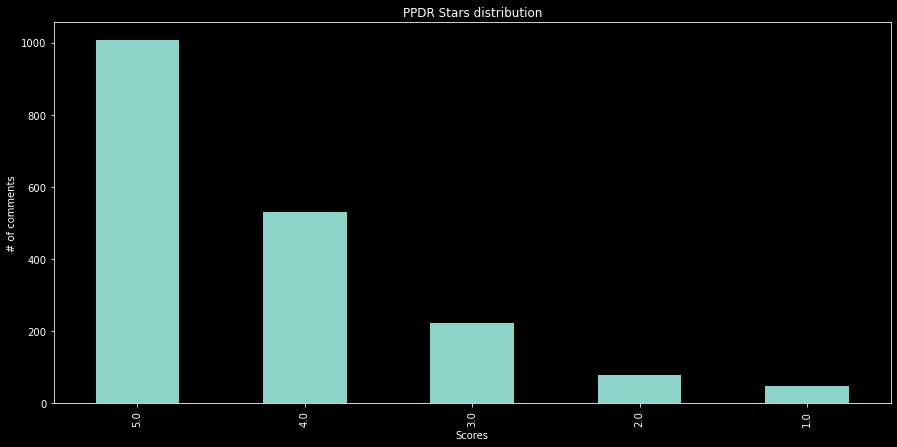

In [6]:
data.score.value_counts().plot(kind='bar', title='PPDR Stars distribution', ylabel='# of comments', xlabel='Scores');

## Timeseries
 
First, let's see how many commentaries the resort has monthly.

In [7]:
data['date2'] = pd.to_datetime(data.date, format='%d %B %Y')
dfd = data.copy()
dfd.set_index(pd.DatetimeIndex(dfd['date2']), inplace=True)
dfd = dfd.sort_index()

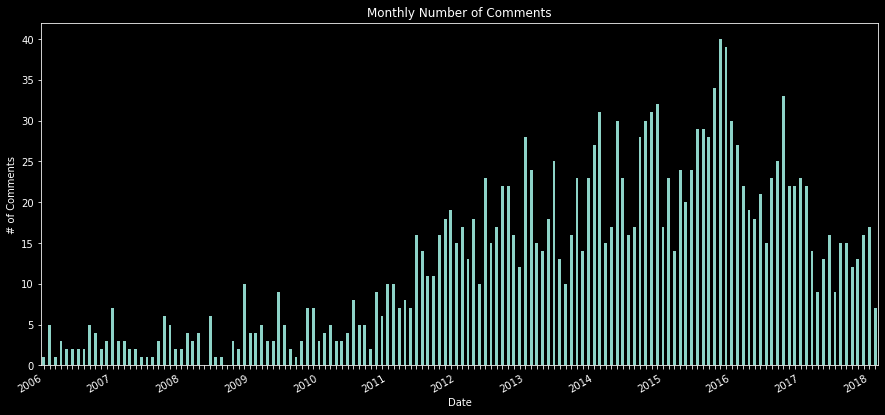

In [8]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

bar_chart = dfd.score.copy()
bar_chart = bar_chart.resample(rule='M').count()
ax = bar_chart.plot(kind='bar', x = bar_chart.index)

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = [''] * len(bar_chart.index)
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%Y') for item in bar_chart.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title('Monthly Number of Comments')
ax.set_ylabel('# of Comments')
ax.set_xlabel('Date')
plt.pyplot.gcf().autofmt_xdate()
plt.pyplot.show()

OK. So since 2012 comments are 20 each month, reaching a pick in 2017 up to 40 comments in a single month. Last year though, the average number of comments drops to 15 per month.

### Score through time

Let's calculate the score average for every month.

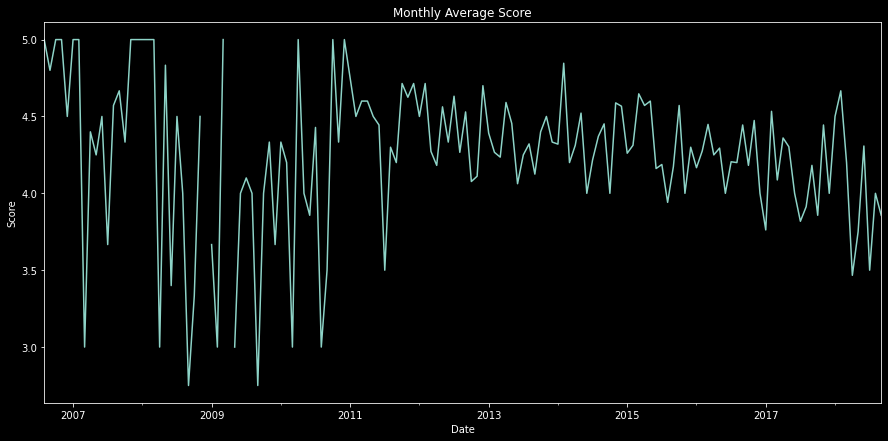

In [9]:
linear = dfd.score.copy()
linear = linear.resample(rule='M').mean()
linear.plot(kind='line', title='Monthly Average Score', ylabel='Score', xlabel='Date');

It seems that before 2012 -when there is few comments- the mean is quite volatile, but then moves aroud 4.3 and its been slighly decreasing. More stable number could be the accumulate version.

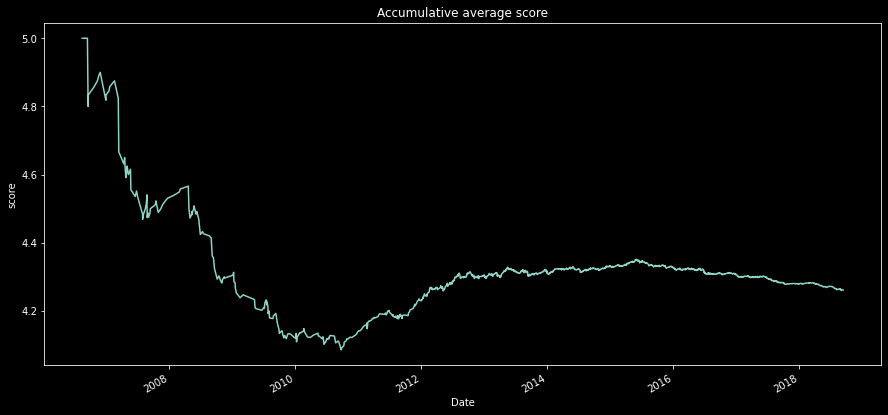

In [10]:
dfd.score.expanding().mean().plot(title='Accumulative average score', ylabel='score', xlabel='Date');

The mean becomes more stable as more reviews are added, therefore, to change a reputation over time requires a lot of new comments of the opposite sign. It means that the initial good reputation was easily lowered at the beginning by a few bad comments but then reverse easily as well. But then, when it reaches a plateau, change is more subtle. So, the `slight decrease, in the end, could be hiding something`.

Let's see the distribution of reviews over time if we normalize the number of reviews. Just take data from 2014 and on to take the initial noise out.

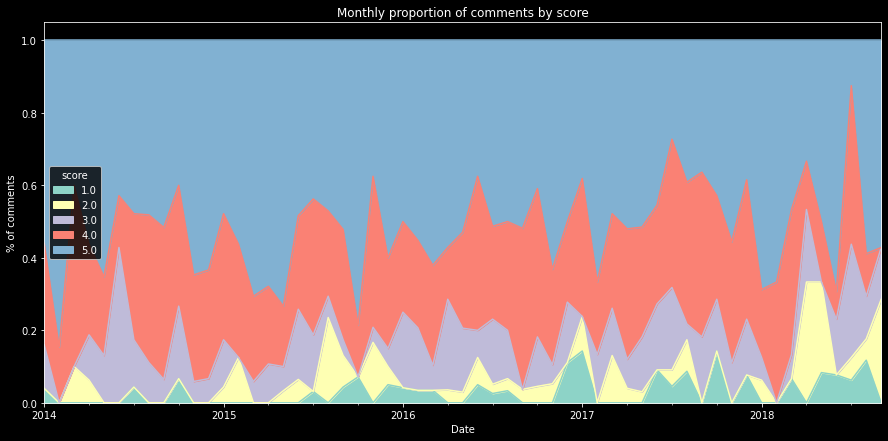

In [11]:
calification = pd.crosstab(dfd.date2, dfd.score)
calification = calification.resample(rule='M').sum()
calification['total'] = calification.sum(axis=1) # calculate a horizontal sum as total
calification = calification.div(calification.total, 0) # divide each column again total column
calification = calification.drop('total', axis = 1) #erase total column

calification.loc['2014':,:].plot(kind='area', ylabel="% of comments", xlabel='Date', title= "Monthly proportion of comments by score");
#calification.head()

It seems that the last year's comments with scores lower than 3 are more common than before. Let's see it with more detail, comparing year after year in separate graphics.

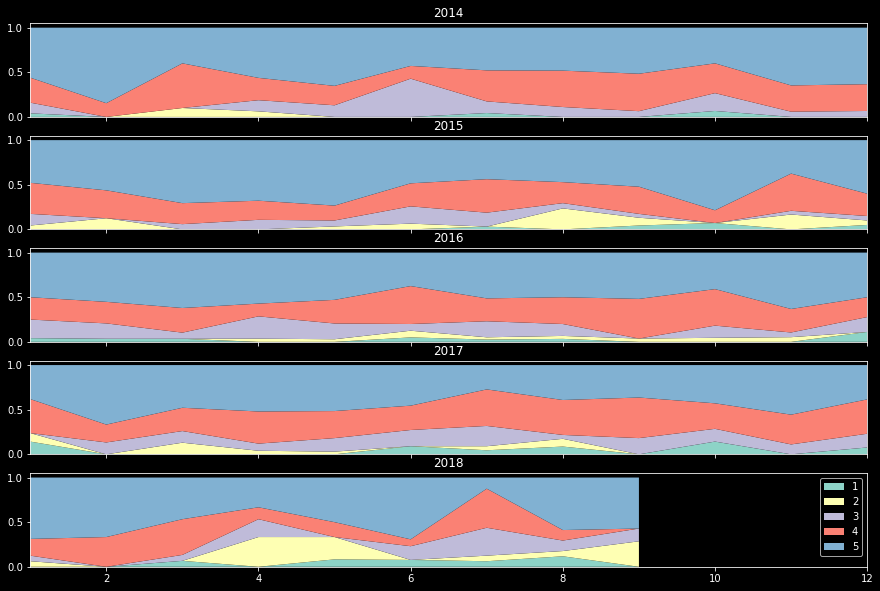

In [12]:
fig, ax = plt.pyplot.subplots(5, 1, sharex='col', sharey='row', figsize=(15, 10))
years = [*map(str, calification.index.year.unique()[8:].tolist())]
x_dates = calification.index.month.sort_values().unique()
for i, year in enumerate(years):
    c = calification.loc[year:year,:]
    ax[i].stackplot(c.index.month, c[c.columns[0]], c[c.columns[1]], c[c.columns[2]], c[c.columns[3]], c[c.columns[4]])
    ax[i].set_xlim(1,12)
    ax[i].set_title(year)
    if i == len(years) - 1: ax[i].legend([*range(1,6)]) # add legend at the end
    

If we check the values in absolute terms, we can see the number of comments with scores lower or equal to 3 remain the same, wherereas the more positive comments have declined. The next two  graphs show the annual trend of positive comments declining.

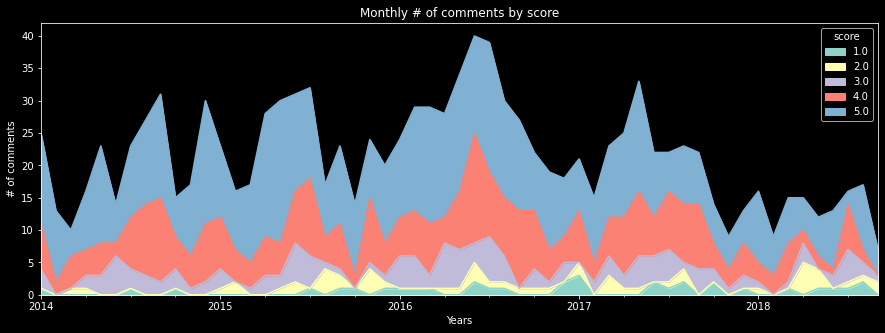

In [13]:
calification_abs = pd.crosstab(dfd.date2, dfd.score)
calification_abs = calification_abs.resample(rule='M').sum()
calification_abs.loc['2014':].plot(kind='area',stacked =True,title = 'Monthly # of comments by score', xlabel='Years', ylabel='# of comments', figsize=(15,5));

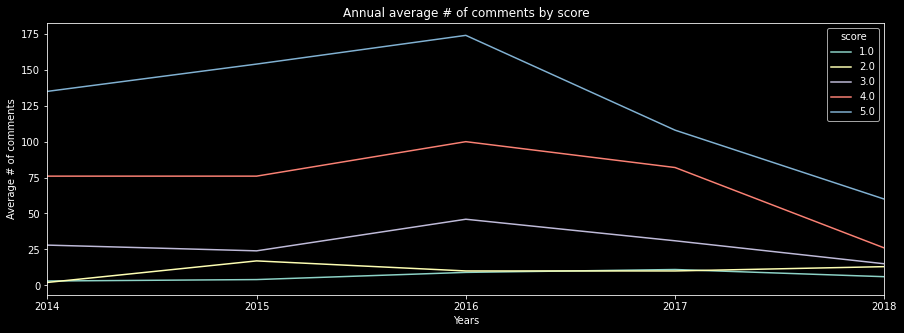

In [14]:
# Averaga number
calification_mean = pd.crosstab(dfd.date2, dfd.score)
calification_mean = calification_mean.resample(rule='Y').sum()
calification_mean.loc['2014':].plot(kind='line', title = 'Annual average # of comments by score', xlabel='Years', ylabel='Average # of comments', figsize=(15,5));

In [15]:
"""
years = map(str, calification_abs.index.year.unique()[8:].tolist())
years = [*years]
for year, i in zip(years[:], range(len(years)-1)):
    calification_abs.loc[year:year,:].plot(kind='area', stacked = True, figsize=(15,4), sharex=True, title="Year {}".format(year))  
calification_abs.loc['2018':'2018',:].plot(kind='area', stacked = True, figsize=(15,4), xlim=(pd.Timestamp('2018-01-31 00:00:00', tz=None),
pd.Timestamp('2018-12-01 00:00:00', tz=None)), title="Year {}".format('2018'));
"""

'\nyears = map(str, calification_abs.index.year.unique()[8:].tolist())\nyears = [*years]\nfor year, i in zip(years[:], range(len(years)-1)):\n    calification_abs.loc[year:year,:].plot(kind=\'area\', stacked = True, figsize=(15,4), sharex=True, title="Year {}".format(year))  \ncalification_abs.loc[\'2018\':\'2018\',:].plot(kind=\'area\', stacked = True, figsize=(15,4), xlim=(pd.Timestamp(\'2018-01-31 00:00:00\', tz=None),\npd.Timestamp(\'2018-12-01 00:00:00\', tz=None)), title="Year {}".format(\'2018\'));\n'

In the `last year there are less positive comments`. Something not good is happening.

## The Comments

Despite previous observations, many reviews are generally positive, but they refer to different things. To make things clearer let's split the reviews into sentences. That way we could note the difference if a comment is about more than one subject.

### Prepare text data and split reviews into sentences

In [16]:
from nltk.tokenize import word_tokenize, sent_tokenize

data_sentence = data[['title','score','comment','date']].copy()
data_sentence.dropna(subset = ['comment'], inplace=True)
data_sentence['sentence'] = data_sentence.comment.apply(sent_tokenize)
data_sentence = (data_sentence['sentence'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True).to_frame('sentence').join(data_sentence[['title','score','comment','date']], how='left'))

Check the new data set with a sentence by row.

In [17]:
data_sentence.reset_index(drop=True, inplace=True)
data_sentence.head()

,sentence,title,score,comment,date
0,5 star prices and 3 star service.,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
1,We stayed in a villa with a private pool which...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
2,The maintenance man even said it’s so hard to ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
3,The food is bang average not just at the hotel...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
4,The staff are all great and try and make your ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018


### Look for meaning (most significative bi-grams)

#### Extract most common bi-grams and tri-grams

To explore the content first I could have a look of the most frequent words. A simple model of sklearn can give us that information. Let’s see some bi-grams and tri-grams.

In [18]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

stp = nltk.corpus.stopwords.words('English') 
data_sentence.sentence.dropna(inplace=True)

vectorizer = CountVectorizer(lowercase=True, stop_words=stp[:130], ngram_range = (2,3), min_df=5).fit(data_sentence.sentence);
full_matrix = vectorizer.transform(data_sentence.sentence);

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 're', 've'] not in stop_words.
  warnings.warn(


In [19]:
def display_scores(vectorizer, tfidf_result, n = 50):
    """
    from http://stackoverflow.com/questions/16078015/

    Display score for a corpus produced by sklearn word vectorizer.
    Return values in descending order.

    @vectorizer: sklearn model (trained)
    @tdft_result: numpy matrix of vocab and vector scores
    @n: int, max number of results. None return all results. 
    """
    scores = zip(vectorizer.get_feature_names_out(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores[:n]:
        print("{0:50} Score: {1}".format(item[0], item[1]))
        
display_scores(vectorizer,full_matrix,25)

sea temple                                         Score: 523
port douglas                                       Score: 512
pool bar                                           Score: 132
staff friendly                                     Score: 107
plunge pool                                        Score: 100
two bedroom                                        Score: 99
bedroom apartment                                  Score: 92
pool area                                          Score: 88
stayed nights                                      Score: 85
room service                                       Score: 84
temple port                                        Score: 81
temple port douglas                                Score: 81
sea temple port                                    Score: 80
front desk                                         Score: 74
lagoon pool                                        Score: 74
friendly helpful                                   Score: 69
golf course        

This is the most frequent combination of words in the reviews. It doesn't seem to be very meaningful. But we can collect some insights. So, besides the name of the resort, the pool and the staff are definitely the most common words (and let me tell you, the pool is upstanding), and must be a very important part of the customer experience. Let's try another technique to get more information.

### Detect keyphases

We can improve the detection of n-grams by detecting keyphrases. For that, I will use word2Vec or word embeddings, that in theory would help to find synonymous to those phrases. It not only will help to create keyphases to identify the text but also will improve the understanding of the text itself.

##### Keyphrases with bigrams

In [20]:
import nltk
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from collections import Counter

data_words = data_sentence.sentence.apply(simple_preprocess, deacc=True).tolist()
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


Now I can clean the sentences and apply the ngram model to the whole corpus.

In [21]:
#Wrap some steps into function to improve understanding
def remove_stopwords(texts):
    return [[word for word in doc if word not in stp[:130]] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

text = remove_stopwords(data_words)
text = make_bigrams(text)
text = make_trigrams(text)

# Let's replace the sentences with the trigams and bigrams
#data_sentence['sentence_prod'] = data_sentence.sentence
data_sentence['sentence_prod'] = pd.Series(text)
data_sentence.sentence_prod = data_sentence.sentence_prod.apply(' '.join)

In [22]:
from gensim.models import Word2Vec

bigram_model = Word2Vec(bigram_mod[data_words])
bigram_model_counter = Counter()
for key in bigram_model.wv.vocab.keys():
    if key not in stp[:130]:
        if len(key.split("_")) > 1:
            bigram_model_counter[key] += bigram_model.wv.vocab[key].count

In [23]:
for key, counts in bigram_model_counter.most_common(30):
    print('{0} \t {1}'.format(key.encode("utf-8"), counts))

b'sea_temple' 	 523
b'port_douglas' 	 512
b'front_desk' 	 74
b'golf_course' 	 67
b'highly_recommend' 	 56
b'roof_top' 	 56
b'shuttle_bus' 	 52
b'well_appointed' 	 47
b'hot_tub' 	 40
b'direct_access' 	 35
b'ground_floor' 	 34
b'barrier_reef' 	 30
b'mile_beach' 	 29
b'school_holidays' 	 29
b'wedding_anniversary' 	 28
b'palm_cove' 	 26
b'five_star' 	 26
b'hire_car' 	 25
b'minute_drive' 	 24
b'four_mile' 	 23
b'ended_up' 	 22
b'washer_dryer' 	 21
b'spiral_staircase' 	 21
b'main_street' 	 20
b've_ever' 	 20
b'young_children' 	 19
b'per_person' 	 19
b'make_sure' 	 19
b'self_contained' 	 18
b'washing_machine' 	 18


Now it looks like we can found some meaning on them. Let's check some interesting ones within context. Because we are only focusing in a sentence within a whole text, let's highlight the sentence words in red.

In [24]:
pd.set_option('display.max_colwidth', None)
from IPython.display import display, Markdown, Latex, HTML

def highlight_selected_text(row, col_keywords = 'sentence_prod', col_full_text = 'comment'):
    """
    Change color of selected keywords within a text to display a Pandas DataFrame as HTML
    """
    text = row[col_full_text]
    ext = row[col_keywords]
    color = {" " + v.replace("_"," "):'red' for v in ext.split(' ')}
    #print(color)
    for k, v in color.items():
        text = text.replace(k, f'<span style="color: {v}; font-weight: bold">{k}</span>')

    return text

In [25]:
data_sentence[['sentence_prod','comment']]

,sentence_prod,comment
0,star prices star service,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
1,stayed villa private pool ok needs updating looks tired,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
2,maintenance man even said hard keep hotels issues,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
3,food bang average just hotel round port_douglas,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
4,staff great try make stay nice fault just think hotel run,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
...,...,...
9531,manager told yes know worth get,"This is a great resort if you like luxurious living. The rooms were nice (and we only got a studio), very comfortable bed, awesome jacuzzi bathtub and great pool. Service was surprisingly good, since we'd heard some bad things prior to coming. Very accomodating staff. You also get your own little garage for your car. The negatives, they provide robes which is like putting sandpaper to your skin, there are sugar ants that may invade your room in the summer (which they do give you spray for if you get them - we had them just one night). Limited menu if you're a vegetarian (so just go into ""town"") and lastly, this place is in the middle of NO WHERE. Off the main street, there's one sign to turn and then no others... we found the golf club and had to go ask where to go from there... they do not make it easy to find. (The manager told me ""Yes, I know, but it's worth it once you get there."" hmmmm.) All in all a great value for the $$$ - we'd go back."
9532,hmmmm,"This is a great resort if you like luxurious living. The rooms were nice (and we only got a studio), very comfortable bed, awesome jacuzzi bathtub and great pool. Service was surprisingly good, since we'd heard some bad things prior to coming. Very accomodating staff. You also get your own little garage for your car. The negatives, they provide robes which is like putting sandpaper to your skin, there are sugar ants that may invade your room in the summer (which they do give you spray for if you get them - we had them just one night). Limited menu if you're a vegetarian (so just go into ""town"") and lastly, this place is in the middle of NO WHERE. Of

In [26]:
display(HTML(data_sentence[['sentence_prod','comment']][data_sentence.sentence_prod.str.contains("front_desk")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
436,"I am not sure where to start with this hotel. First, on a positive note, the front desk staff was nice and helpful. But the positives stop there. Our room looked dated and beaten up. Bedside lamps were falling apart. Cleaning left much to be desired with mould growing in the bathroom and dust all over the bedside lamps. We were visited by large roaches which apparently is normal in this climate but still disgusting. Food was definitely well below par. Room service was plain disgusting with chicken nuggets that looked burnt and refried several times. Breakfast was also bad with soggy hash browns and watery scrambled eggs. Please note the beach is nearby but full of large jellyfish from November to May so no swimming allowed. Overall we had paid top dollars for this place and this was the poorest value for money in our entire trip. The hotel needs a full refurbishment and a new chef for sure."
380,"The rooms vary in style and size; some smaller, some large with full kitchens, laundry, and barbecues. Rooms could use upgrades. Pool was a bit dirty. Staff at the hotel restaurant was not engaged, the food was not very good, and the staff did not keep the food trays filled. Services is slow. Front desk staff did not seem interested. The spa was not staffed.internet spotty and slow. Possible that the maintenance issues were because this is a time share resort."
6928,"We stayed at the Sea Temple over Easter and were really impressed. We were upgraded to a enormous 2 bedroom, 2 bathroom penthouse, with a huge private rooftop terrace with jacuzzi and BBQ. The decor in the rooms was fresh and comfortable. We made full use of the kitchen facilities, BBQing each night. The pool is fantastic, it was great swimming at night under the stars. The resort was about a 10 min drive from Port Douglas, but it seemed most of the resorts were located out of town. The resort staff were fantastic, from the helpful front desk staff who checked us in and recommended an booked our reef tour to the housekeeping staff who would happily work around our schedule. Would definitely recommend the Sea Temple, we had a lovely stay."


It seems that the guys at frond desk are doing a great job. 

In [28]:
display(HTML(data_sentence[['sentence_prod','comment']][data_sentence.sentence_prod.str.contains("shuttle_bus")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
1393,"Lovely resort feeling, swimming pool is massive but is not solar heated so it is refreshing. Pool bar open daily good service. Rooms are tired and need a bit of TLC. Our room also only had 1 bathroom which was hard for the family to get used to! Our room had plunge pool and outdoor BBQ area which was a great space but needs overhead light at BBQ area as it's difficult to see what your actually cooking and eating. Our room wasn't serviced daily but when reception informed attended to. Great local shuttle bus takes you into town centre, only ever waited 5mins for driver to appear. Locals use this service as well as other resorts so you do have to be patient as you are driven around to pick up others on way in to town,but I liked seeing other resorts and where the locals live. Restaurant is fine dining,lovely food and kids menu good."
7966,"We stayed for a few nights in this hotel, in a spacious standard room with spa bath, overlooking the lagoon pool, which was lovely. The hotel has all the usual facilities and a very grand lobby. Staff very friendly and helpful. The hotel is located next to beach, but about a 10 min drive from the centre of port Douglas. I believe they run a shuttle bus into town. Golf enthusiasts would love the golf course nearby."
2332,"We stayed here for 3 nights on our road trip around Australia. The hotel itself is situated about 4 miles from Port Douglas. That isn't a problem as there is a local 'industry' that has build up of people providing shuttle buses to and from the hotels to PD. It works well, you get in pay and they take you. It's pot luck which one you get as you jump in the first one you see on your first trip. We got offered a deal of $25 per person unlimited for 3 days. We were in the money as it was $9 return per person. We saved overall."


This is surprising. As the resort seems to be away from town, shuttle buses are an important factor in the customer's experience.

In [29]:
display(HTML(data_sentence[['sentence_prod','comment']][data_sentence.sentence_prod.str.contains("direct_access")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
8209,"We recently enjoyed a weekend at Sea Temple Port Douglas, sure it is the wet season but we took the gamble and went up any way. We are so glad we did, the weather was perfect. The resort is well planned and maintained. We had a three bedroom penthouse apartment for four nights which was booked through the apartment owners', and not the resort itself - a fact we didn't know until we got there. This meant being met by the booking agent for check in, (key handover) and not checking in at the resort desk. It also meant that if we had any queries or problems throughout our stay, that we would contact the booking agent and not the concierge or front desk. Our room included a rooftop spa and BBQ and not direct access to the pool which really wasn't a problem as the pool is very easily access able anyway. Being summer the rooftop spa wasn't very refreshing so we didn't bother using it, but the BBQ got a great workout. The kitchen was very clean with an oven big enough to accommodate our needs. Although this resort has a shuttle bus, I recommend car hire for the convenience of it and also the time saving factor. Why spend time in the shuttle bus when you can laze around the pool drinking cocktails. Give yourself plenty of time when ordering drinks, on the first day our drinks took two and a half hours to arrive, apparently the barman didn't have enough glasses despite the being used glasses and plates lying around waiting for clean up from areas of private access from ground floor rooms."
7185,"We had just gotten off our cruise on the Crystal Cruise line in Brisbane and flew to Cairns. Had a lovely drive along the Coral Sea to Port Douglas about one hour from the airport. It reminded me of the Amalfi Coast with its winding roads and beautiful scenery. We arrived at the Sea Temple Resport and Spa and were greeted by a very friendly staff member. All the staff was wonderful and helpful when we arrived. The opened air lobby had a beautiful view of the very large pool area. We were driven by golf cart to our room. My travel agent said she got us a penthouse suite, but when we got into our apartment (which is almost that same size as our apartment in the states) we were astounded by how spacious and beautiful is was. It is decorated very tastefully with all you could want. Washer dryer, dishwasher, large refrigerator, microwave. We could easily have stayed for months. Not only were the rooms nice, but the verandah was spacious also with a couch, 2 chairs and a table. Then I noticed a spiral staircase outside and it led to an upstairs that had a hot tub, barbecue grill and table and chairs. We wanted to move right in. We were on the second floor and the first floor rooms have access to the lazy river pool right outside their verandah. There was no direct access from our room to the lobby. You could walk but it was pretty hot, so you just call the front desk and they come with the golf cart to pick you up. The staff also helped with setting up tours and gave us some restaurant tips. Too bad we were only there for 3 days. We didn't get to see everything we wanted. Took a shuttle to town one night but it was around 6 and all the stores were closed, which I thought was strange as it is a resort town. Then I was told it is off season, but we did happen upon a great restaurant called Nautilis which had a long access to the main area but once you get there you think you just entered a tropical jungle. Beautiful and very romantic. January is a tricky time of year there, it's hot but it can also be very rainy. We were lucky that the weather was great when we went to the Great Barrier Reef, but on our last day it rained all day. All in all it was a very nice way to end our fabulous cruise and stay in Australia. We just loved the country and the people."
3922,"What a stunning resort! It has an amazing pool that weaves itself throughout most of the apartments / rooms which allows direct access from your room straight into the pool . We however 

People are astonished by the direct access to the pool. As we see previously the pool is one of the most common words in reviews. It is quite an impressive pool. I would bet is the main selling factor of the resort.

##### Keyphrases with postagging selection

Another way to try to define some keyphrases is to try to get subject (Nouns and pronouns) and adjetives of each sentences.

In [31]:
import spacy
nlp = spacy.load('en_core_web_md')

def get_chunk(sent, chunk=["NOUN",'PROPN','VERB']):
    """
    Function to extract selected post-tag chunks
    """
    chunks, dep, tt = [], [], []
    for w in sent:
        if w.pos_ in chunk:
            chunks.append(w.text)
        if w.tag_ == "JJ":
            dep.append(w.text)
        if w.dep_ == "neg":
            tt.append(w.text)       
    return chunks + tt + dep

data_sentence['new_col'] = data_sentence.sentence.apply(nlp)
data_sentence['keywords'] = data_sentence.new_col.apply(get_chunk)#,chunk=["NOUN"])
keywords = data_sentence.keywords.apply(' '.join)

If we collect the most (noun) common words we could use them to classify comments later.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
common_words = cv.fit(keywords)
kw = common_words.transform(keywords)
display_scores(common_words, kw, 25) 

pool                                               Score: 1567
room                                               Score: 1120
resort                                             Score: 1071
had                                                Score: 961
not                                                Score: 898
staff                                              Score: 768
great                                              Score: 764
stayed                                             Score: 685
stay                                               Score: 659
hotel                                              Score: 596
spa                                                Score: 569
apartment                                          Score: 541
sea                                                Score: 534
port                                               Score: 527
temple                                             Score: 527
douglas                                            Score: 523
servi

Ok. Pool, room and staff are the most common (noun) words once again. Its seems that much of the experience are defined by those factors. Other words are not surprisingly common, as the name, "resort" and "hotel". Some others are other areas and services of the resort as the "restaurant".

But there is three that instrigin me: "area", "time", "town".
Let's see if we could get something of context for each of theses words.



In [34]:
data_sentence.sentence_prod[data_sentence.sentence_prod.str.contains('area|time|town')].sample(9)

5661                                                                    would normally stay peppers beach club just walk beach town pool grounds big
5554                                                                thing plunge pool time year freezing cold takes breath away could enjoy dip pool
6778      husband celebrated year wedding anniversay great relaxing time would highly_recommend couples families exceptional service attention areas
7080                                                                                                          whole pool area massive photos justice
8464                                                 apartment well equipt full kitchen dinning area lounge open_plan laundry ideal weeks travelling
4685                                                                                                               beach access dedicated beach area
2014                                                        traveling family recommend poolside room kids 

So "area" refers to many places like `bbq area`. Then, "time" is about `how many times a customer has been in the resort`.

But the third one is the most interesting. Is the `distance to the "town"` that appears in the comments reflecting some of the differences with other big resorts in the area. Again, as we notice with the `shuttle bus services`, this is an important factor in the experience of someone staying at the resort. If they flew or they drive to Port Douglas makes a difference. This is especially true as many of the rooms are self-contained, which means they have a kitchen and you need to go to the supermarket in order to have food to cook in that kitchen, and to do so, you need a car, otherwise, you have to walk a lot.

I would say that Sea Temple is preferred by the customer that can drive to it. If not, you need really improve that part of the experience of those who don't.

## Semi-Supervised Classification of text (from zero labels)

Sometimes is hard to try to evaluate comments through time. There is a bias toward the last comment we read, and we tend to forget the first ones.
So, for a more systematic analysis let's organise the comments to get a better understanding of what they said.

For this, I could use representations of the text. I could try to get some descriptors as markers and show how they distribute through time. This will allow me to make visualisations of key concepts in the text.

As there are different areas within a hotel is valuable to identify markers referred to reception, housekeeping and maintenance or food and beverage departments. I also found it interesting to add another marker for infrastructure and environment.

I cannot read every comment, so I will give a list of words that could be in for each marker (department). Then I'll create an algorithm to find the similarity between the lists and each sentence. If the algorithm found similar to any of the lists, it will classify (mark) the sentence as belonging to that list (department).

Also, we can check some words related to a few keywords

In [68]:
bigram_model.wv.similar_by_vector('restaurant')

[('food', 0.9804224967956543),
 ('service', 0.9735562801361084),
 ('excellent', 0.9713994860649109),
 ('breakfast', 0.9710830450057983),
 ('bar', 0.9596787095069885),
 ('great', 0.9572246074676514),
 ('amazing', 0.9463927745819092),
 ('beautiful', 0.9443619847297668),
 ('exceptionally', 0.9413618445396423),
 ('good', 0.9411993026733398)]

In [69]:
bigram_model.wv.similar_by_vector('housekeeping')

[('welcoming', 0.9982988834381104),
 ('always', 0.9976476430892944),
 ('efficient', 0.9972100257873535),
 ('super', 0.9968487024307251),
 ('polite', 0.9961002469062805),
 ('obliging', 0.9960570335388184),
 ('front_desk', 0.9957461953163147),
 ('accommodating', 0.9951769709587097),
 ('exceptional', 0.994606614112854),
 ('greeted', 0.994085431098938)]

If we expand this idea to the whole dataset...

In [35]:
# Spacy way using keywords
topic_labels = [
  'Food & Beverage',
  'Housekeeping',
  'Front desk',
  'Environment'
]
# I give a list of words for every topic based on the most common topics
topic_keywords = [
  'food drink breakfast burger waitress chef wine delicious taste chips beer restaurant bar',
  'clean sheets toilet bathroom housekeeping bed furniture linen dirty',
  'front desk reception luggage call welcome check booking phone',
  'location atmosphere pool terrace parking beach town lobby maintenance repair'    
]

In [36]:
# Create topic example vectors with Glove
topic_docs = list(nlp.pipe(topic_keywords,
  batch_size = 10000,
  n_process = 4 ))
  
topic_vectors = np.array([doc.vector 
  if doc.has_vector else doc.vocab[0].vector
  for doc in topic_docs])

# Create document vectors baded on keywords
keyword_docs = list(nlp.pipe(keywords,
  batch_size=10000,
  n_process=4))
  
keyword_vectors = np.array([doc.vector 
  if doc.has_vector else nlp.vocab[0].vector
  for doc in keyword_docs])

Now I have the vector for every sentence, I'm able to find the topic for each of them by measuring similarity between sentence vectors and topic vectors and picking the closest. I could define a threshold in the case of the similarity within every topic being too low and save it into a "something else" topic.

In [37]:
from sklearn.metrics.pairwise import cosine_similarity
# use numpy and scikit-learn vectorized implementations for performance
simple_sim = cosine_similarity(keyword_vectors, topic_vectors)
topic_idx = simple_sim.argmax(axis=1)

topic = []
distance = []
for k, i, j in zip(keywords, topic_idx, simple_sim):
    distance.append(j[i])
    if j[i] > 0.55:
        topic.append(topic_labels[i])
    else:
        topic.append("something else")


In [38]:
com = []
for scr in simple_sim:
    a, b = np.argpartition(scr, -2)[-2:]
    t = abs(scr[b]-scr[a])
    if (t < 0.001) and (scr[b] > 0.55):
        com.append(topic_labels[a] + " " + topic_labels[b])
        print(t, topic_labels[a],topic_labels[b], scr[b])

pd.Series(com).value_counts()

0.00011789799 Environment Front desk 0.67784023
0.0005286932 Environment Front desk 0.61320555
4.3988228e-05 Housekeeping Environment 0.70479393
0.00028854609 Front desk Environment 0.59262854
0.00043940544 Environment Housekeeping 0.6275188
1.1622906e-05 Environment Front desk 0.68489677
0.00060904026 Housekeeping Front desk 0.6076406
0.0003233552 Housekeeping Environment 0.63021237
0.000472188 Front desk Housekeeping 0.6061547
0.000859499 Housekeeping Environment 0.7485435
0.00029683113 Front desk Housekeeping 0.59655523
2.3126602e-05 Housekeeping Environment 0.6757443
0.0004826188 Front desk Environment 0.67436737
2.1100044e-05 Environment Housekeeping 0.6540362
0.00025987625 Environment Housekeeping 0.7032268
0.0005918145 Environment Housekeeping 0.6655362
0.00017797947 Environment Front desk 0.6442132
0.00071394444 Environment Food & Beverage 0.6794119
0.00083589554 Housekeeping Environment 0.6043813
0.00053328276 Front desk Housekeeping 0.6469085
0.00059491396 Front desk Housekee

Housekeeping Environment        15
Environment Housekeeping        14
Environment Front desk          11
Front desk Housekeeping          7
Front desk Environment           3
Housekeeping Front desk          3
Environment Food & Beverage      2
Food & Beverage Environment      1
Housekeeping Food & Beverage     1
dtype: int64

In [39]:
data_sentence['topic'] = topic
data_sentence['distance'] = distance

<AxesSubplot:ylabel='Frequency'>

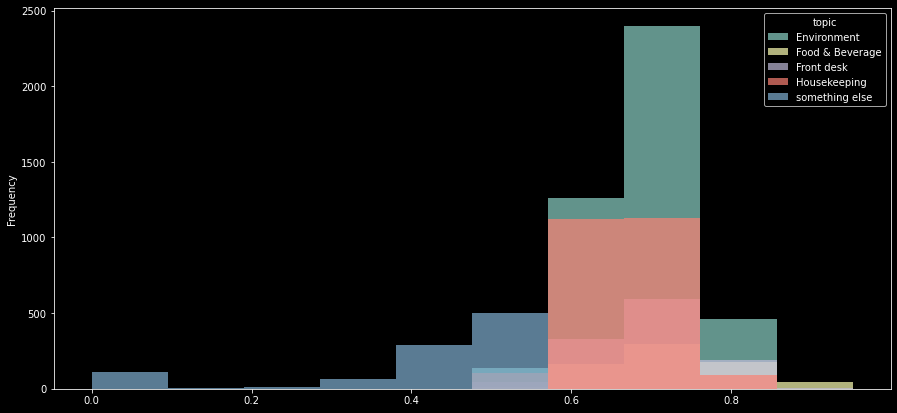

In [41]:
data_sentence[['distance','topic']].pivot(columns='topic',values='distance').plot.hist( alpha = 0.7)

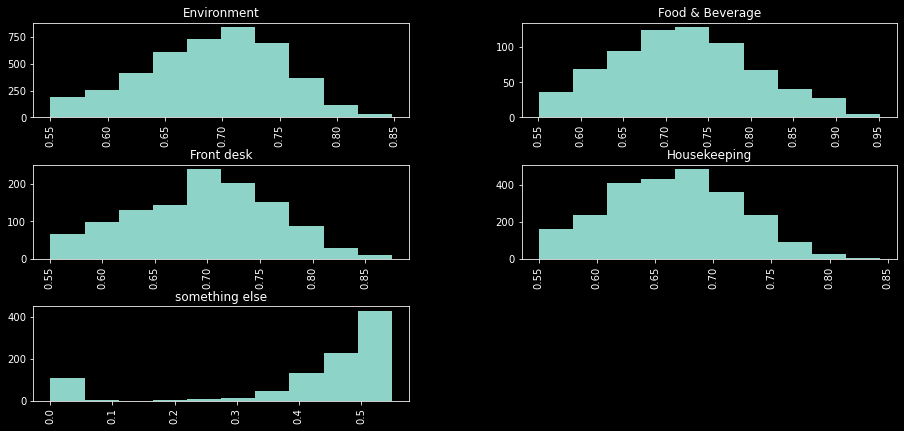

In [50]:
data_sentence['distance'].hist(by=data_sentence['topic']);

Have a look how topics distribute. Its seems Food & Bevarage has the less of mentions, meanwhile enviroment is the largest category.

In [43]:
data_sentence.topic.value_counts()

Environment        4251
Housekeeping       2451
Front desk         1158
something else      980
Food & Beverage     696
Name: topic, dtype: int64

In [44]:
data_sentence[data_sentence.topic=='Front desk'].sample(1)

,sentence,title,score,comment,date,sentence_prod,new_col,keywords,topic,distance
5409,This is a classy and well managed resort with wonderful and very helpful staff right from the reservation staff to all the housekeeping and maintenance staff .,excellent stay,5.0,"Right from the time we made our booking direct with sea temple we new we would have a memorable holiday .We as a family booked two beach side 3 brm villas for two weeks . Just amazing . The villas were very well appointed and spacious allowing us as a family to be able to enjoy our holiday in a relaxed and very comfortable accom . The villas had there own plunge pool which considering it was the end of Aug we were able to swim in . The villas have there own BBQ and again we used these on a number of occasions . The BBQ was cleaned and checked every day . We all enjoyed the main pool along with the helpful staff at the pool bar . Great service here when ordering a bite to eat. As a adult family of 10 we at different times experienced the Aqua restaurant for breakfast ,lunch and a formal dinner . All of the family really enjoyed the meals and service we received . The front desk again very helpful from the moment we checked in. Booking golf at the palmer sea reef course and a few tours were no problem to them . This is a classy and well managed resort with wonderful and very helpful staff right from the reservation staff to all the housekeeping and maintenance staff . Well done sea temple ... we will be back",6 September 2014,classy well managed resort wonderful helpful staff right reservation staff housekeeping maintenance staff,"(This, is, a, classy, and, well, managed, , resort, with, wonderful, and, very, helpful, staff, right, from, the, reservation, staff, , to, all, the, housekeeping, and, maintenance, staff, .)","[managed, resort, staff, reservation, staff, housekeeping, maintenance, staff, classy, wonderful, helpful]",Front desk,0.790584


In [49]:
data_sentence[data_sentence.topic=='Housekeeping'].sample(1)

,sentence,title,score,comment,date,sentence_prod,new_col,keywords,topic,distance
6728,"Perhaps one of the most disappointing aspects of the rooms are the beds, we were in the main bedroom and had a small queen size bed with average linen.",Good but not 5 star in my opinion,4.0,"We recently stayed at this resort for 6 nights with another couple. We had heard good reviews about the resort and were looking forward to our stay. We stayed in a 2 bedroom penthouse, the room was adequate although not as luxurious as other 5 star resorts we have stayed at recently. Perhaps one of the most disappointing aspects of the rooms are the beds, we were in the main bedroom and had a small queen size bed with average linen. Usually we would stay at a Westin/Sofitel/St Regis or Banyan Tree all of which have super size King which is the norm for a 5 star resort. The beds were very firm and there was no pillow menu. I also found the pillow uncomfortable. The showers were also a little on small size.",21 June 2013,perhaps one disappointing aspects rooms beds main bedroom small queen size bed average linen,"(Perhaps, one, of, the, most, disappointing, aspects, of, the, rooms, are, the, beds, ,, we, were, in, the, main, bedroom, and, had, a, small, queen, size, bed, with, average, linen, .)","[aspects, rooms, beds, bedroom, had, queen, size, bed, linen, disappointing, main, small, average]",Housekeeping,0.755013


Since I have our sentences classified I'm hable to show its distribution through time.

In [51]:
data_sentence['date2'] = pd.to_datetime(data_sentence.date,format='%d %B %Y')
dmd = data_sentence.copy()
dmd.set_index(pd.DatetimeIndex(dmd['date2']), inplace=True)
dmd = dmd.sort_index()

In [52]:
categories = pd.crosstab(dmd.date2, dmd.topic)
categories = categories.resample(rule='M').sum()
categories['total'] = categories.sum(axis=1)
categories = categories.div(categories.total,0)
categories = categories.drop('total',axis=1)
categories.head()

topic,Environment,Food & Beverage,Front desk,Housekeeping,something else
date2,,,,,
2006-12-31,0.461538,0.000000,0.000000,0.384615,0.153846
2007-01-31,0.307692,0.076923,0.076923,0.307692,0.230769
2007-02-28,0.333333,0.083333,0.166667,0.250000,0.166667
2007-03-31,0.833333,0.000000,0.000000,0.166667,0.000000
2007-04-30,0.454545,0.090909,0.181818,0.272727,0.000000


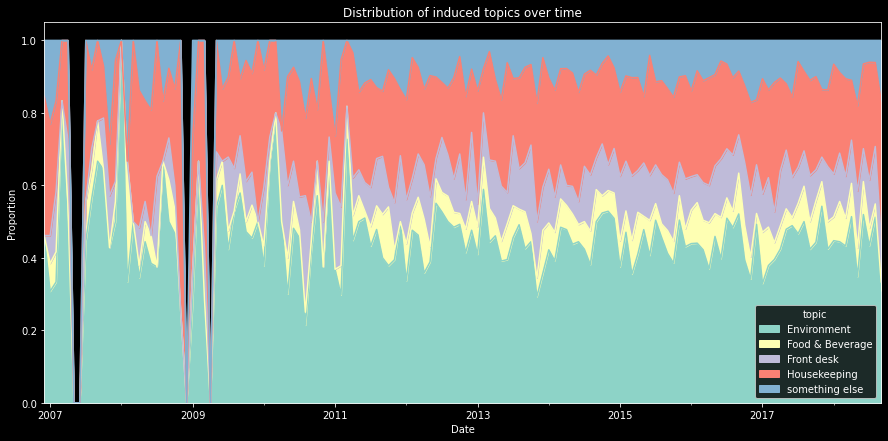

In [53]:
categories.plot(kind='area', title = 'Distribution of induced topics over time', ylabel = 'Proportion', xlabel = 'Date');

It seems the proportion holds through time. While is very noisy. Let's simplify it a bit by just checking the latest year.

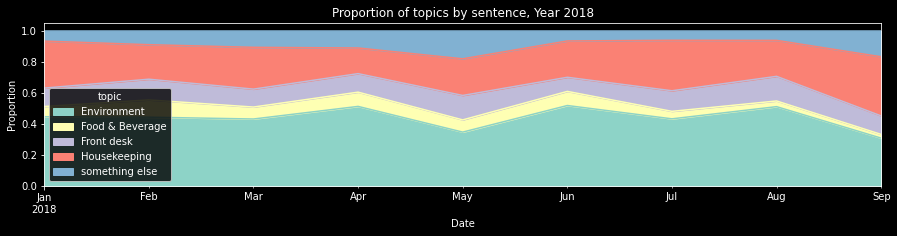

In [54]:
#categories.loc['2014':'2014',:].plot(kind='line',figsize=(12,3))
#categories.loc['2015':'2015',:].plot(kind='line',figsize=(12,3))
#categories.loc['2016':'2016',:].plot(kind='line',figsize=(12,3))
#categories.loc['2017':'2017',:].plot(kind='line',figsize=(12,3))
categories.loc['2018':'2018',:].plot(kind='area',figsize=(15,3), title='Proportion of topics by sentence, Year 2018', xlabel='Date', ylabel='Proportion');

It seems that something else is becoming more important in comments. But also Housekeeping. Probably should explore that content with other algorithms.

## Other way to classify reviews: LDA

I used word2vec to automatic classify sentences. But there are other options available. For instance, We could do some topic modelling. The standard algorithm is Latent Dirichlet Allocations or LDA, which will cluster sentences in a given number of topics. We have several ways to procced here. 

### Regular LDA

First we need to determinate the proper numer of topics. As this is a unsupervised technique, we can only use some heuristics. To do so, I will use perplexiy and coherence score.

In [55]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
np.random.seed(100)

common_dictionary = Dictionary(text)
common_corpus = [common_dictionary.doc2bow(i) for i in text]
# the model on the corpus.
lda = LdaModel(common_corpus, id2word = common_dictionary, num_topics = 20, random_state=90)

In [56]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, common_corpus,common_dictionary, mds='tsne');
panel

c:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared 

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
14     -10.878068   10.538728       1        1  7.016642
4      -60.884026  -75.591820       2        1  6.680997
7       -2.336119  -53.289074       3        1  6.546560
8      -61.385319  -12.914634       4        1  6.420200
0      -28.737743  126.296997       5        1  6.308632
11       1.066606 -123.552811       6        1  5.878338
12      45.140720   -7.947869       7        1  5.462439
6     -140.795975  -98.530548       8        1  5.431319
18      61.531681  -83.240562       9        1  5.186605
19     -72.563057 -140.396881      10        1  4.830076
5       15.984491   63.578186      11        1  4.785397
2     -160.851624   68.945145      12        1  4.454649
9       85.961830   51.922935      13        1  4.322475
15     -99.020836  109.936348      14        1  4.112931
13    -176.764130   -8.681684      15        1  4.061368
1     -117.189880  -37.420200      16        1  3.981283
16     108.829918  -22.946203      17        1  3.841706
10      47.588097  121.934814      18        1  3.775097
3     -106.467834   30.176889      19        1  3.632442
17     -50.613804   59.328842      20        1  3.270845, topic_info=           Term         Freq        Total Category  logprob  loglift
6          pool  1546.000000  1546.000000  Default  30.0000  30.0000
32        staff   748.000000   748.000000  Default  29.0000  29.0000
53   sea_temple   693.000000   693.000000  Default  28.0000  28.0000
8        stayed   733.000000   733.000000  Default  27.0000  27.0000
50       nights   345.000000   345.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
342       night    27.231822   336.762761  Topic20  -4.5025   0.9051
32        staff    28.809058   748.686702  Topic20  -4.4462   0.1625
52       resort    25.439355  1033.166925  Topic20  -4.5706  -0.2840
23        hotel    24.067793   637.552988  Topic20  -4.6260   0.1434
61         room    21.255543  1144.902628  Topic20  -4.7502  -0.5663

[1309 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
179       1  0.350148  absolutely
179       2  0.021221  absolutely
179       4  0.254653  absolutely
179       6  0.021221  absolutely
179       9  0.010611  absolutely
...     ...       ...         ...
2222      2  0.093189         yet
2222     19  0.885294         yet
1803     17  0.857827          yo
1934      2  0.958658       young
1163     10  0.888556       yummy

[4161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 5, 8, 9, 1, 12, 13, 7, 19, 20, 6, 3, 10, 16, 14, 2, 17, 11, 4, 18])

### Simple LDA evaluation

In [57]:
from gensim.models import CoherenceModel

cm_lda = CoherenceModel(model=lda, texts=text, dictionary=common_dictionary, coherence='c_v')
cm_lda.get_coherence()

0.34932208003841125

Ok, topics seems to be very well defined (no superpositions), but coherence is very low. Let's try something else like mallet LDA implementation.

### Mallet implementation LDA

In [59]:
import os
os.environ.update({'MALLET_HOME': '..\\mallet-2.0.8\\'})
mallet_path = '..\\mallet-2.0.8\\bin\\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=common_corpus, num_topics=20, id2word=common_dictionary)
ml_lda = CoherenceModel(model=ldamallet, texts=text, dictionary=common_dictionary, coherence='c_v')
ml_lda.get_coherence()

0.3975106857838676

So now we have an improvement over previous implementation. Let's define the number of topics using the elbow method.

In [60]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, seed = 100):
    """
    Compute c_v coherence for various number of topics

    @dictionary : Gensim dictionary
    @corpus : Gensim corpus
    @texts : List of input texts
    @limit : Max num of topics

    Returns:
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = seed)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=common_dictionary, random_seed= seed)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
    
limit = 60
start = 2
step = 6

model_list, coherence_values = compute_coherence_values(dictionary=common_dictionary, 
                                                        corpus=common_corpus, texts=text, 
                                                        start=start, limit=limit, step=step, seed = 10)

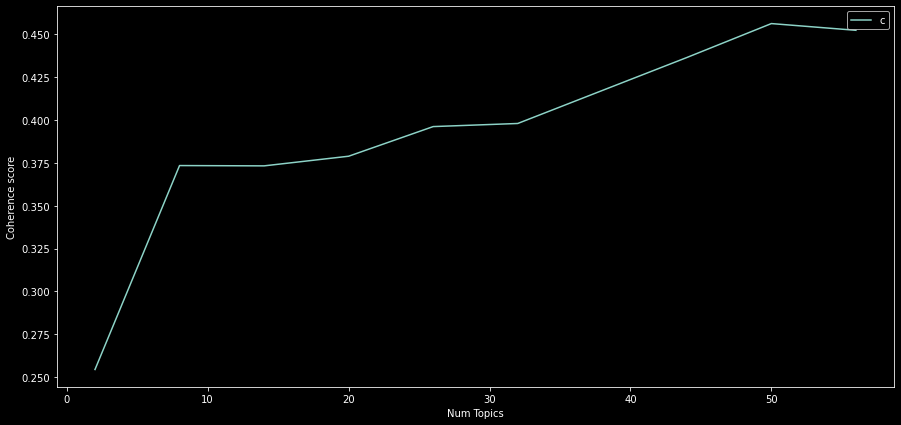

In [61]:
x = range(start, limit, step)
plt.pyplot.plot(x, coherence_values)
plt.pyplot.xlabel("Num Topics")
plt.pyplot.ylabel("Coherence score")
plt.pyplot.legend(("coherence_values"), loc='best')
plt.pyplot.show()

In [62]:
[*zip(coherence_values,x)]

[(0.2544964205296761, 2),
 (0.37337744795312794, 8),
 (0.37320284346212385, 14),
 (0.3788199000503809, 20),
 (0.39609828907325, 26),
 (0.3979079402625484, 32),
 (0.41714161947175665, 38),
 (0.4363556296107168, 44),
 (0.45614544629807957, 50),
 (0.4522246571062397, 56)]

In [64]:
print('Score with 20 topics: {0} \nMax Score with {1} topics: {2}\nMax Score with few ({3}) topics: {4}'.format(
    coherence_values[3],x[np.argmax(coherence_values[:])],max(coherence_values[:]),x[np.argmax(coherence_values[:5])],max(coherence_values[:5])))

Score with 20 topics: 0.3788199000503809 
Max Score with 50 topics: 0.45614544629807957
Max Score with few (26) topics: 0.39609828907325


In [68]:
n_topics = np.argmax(coherence_values[:5])
model_mallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model_list[n_topics])
pyLDAvis.gensim_models.prepare(model_mallet, common_corpus,common_dictionary, mds='tsne')

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-package

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      -56.786537 -118.819275       1        1  3.944566
19      54.703602  213.329483       2        1  3.917776
6      121.354126   -1.907568       3        1  3.906845
4      -36.194469  189.768021       4        1  3.874466
25     -18.847231 -193.712296       5        1  3.874003
22       3.742598  114.107315       6        1  3.867879
14      74.283340 -171.167007       7        1  3.864113
17      42.053726  -21.985979       8        1  3.859448
10      59.034065   52.485435       9        1  3.859057
20    -165.262436   73.180870      10        1  3.849434
5      164.627792  161.830887      11        1  3.843225
15    -188.484436  -19.228041      12        1  3.842325
21     164.233261 -134.414612      13        1  3.842133
8      -15.824605   35.759415      14        1  3.839162
7       21.924309 -100.659660      15        1  3.837820
23    -126.462074  162.305344      16        1  3.836923
1      138.334518   75.351639      17        1  3.834266
13     -72.340935   95.443169      18        1  3.832886
18     -94.678162   19.437422      19        1  3.829751
2       79.247017  132.678772      20        1  3.828497
9       99.738625  -78.556564      21        1  3.825350
24    -112.953316  -57.181133      22        1  3.815200
16     195.611450  -44.628304      23        1  3.809295
3     -144.459625 -140.216187      24        1  3.795337
11     217.684998   47.900742      25        1  3.786277
12     -32.954151  -38.686142      26        1  3.783967, topic_info=          Term         Freq        Total Category  logprob  loglift
6         pool  1881.000000  1881.000000  Default  30.0000  30.0000
61        room  1384.000000  1384.000000  Default  29.0000  29.0000
52      resort  1314.000000  1314.000000  Default  28.0000  28.0000
28       great   972.000000   972.000000  Default  27.0000  27.0000
32       staff   885.000000   885.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1635    simply    15.916289    31.948624  Topic26  -5.1852   2.5776
1183  serviced    13.467629    27.081723  Topic26  -5.3523   2.5758
2137     winds     9.794639    13.412754  Topic26  -5.6707   2.9600
677      range     9.794639    19.489176  Topic26  -5.6707   2.5864
1988    shared     9.794639    19.489176  Topic26  -5.6707   2.5864

[1572 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
179      19  1.000502      absolutely
273      11  0.998104          access
1341     20  0.777026     accessories
239      23  1.011791   accommodating
856      15  1.003441   accommodation
...     ...       ...             ...
1934     17  0.076489           young
1934     21  0.917864           young
865       4  0.220973  young_children
865      21  0.795504  young_children
1543     18  0.893512         zealand

[2046 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 20, 7, 5, 26, 23, 15, 18, 11, 21, 6, 16, 22, 9, 8, 24, 2, 14, 19, 3, 10, 25, 17, 4, 12, 13])

Let's select the most representative topic to understand better its content

In [69]:
def topic2DF(ldamodel, corpus, text):
    """
    ldamodel: Gensim ldamodel
    corpus: List of
    text: list of keywords

    Return: Pandas DataFrame with most likely topic by text, the probability score of a text 
    to belong to that topic, topic keywords and original text, using a trained lda model.
    """
    topic_n_list, topic_prob_list, topic_kw_list = [], [] , []
    for row in ldamodel[corpus]:
        topic_num, prop_topic = max(row, key= lambda x: x[1])
        topic_n_list.append(topic_num)
        topic_prob_list.append(round(prop_topic, 4))

        wp = ldamodel.show_topic(topic_num)
        topic_kw_list.append(", ".join([word for word, prop in wp]))

    return pd.DataFrame({'Dominant_Topic':topic_n_list, 
    'Perc_Contribution': topic_prob_list, 'Topic_Keywords': topic_kw_list,
    'Content': text})

df_topic_sents_keywords = topic2DF(ldamodel = model_list[n_topics], corpus=common_corpus, text=text)


In [73]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

topics_resume = df_dominant_topic.groupby(['Dominant_Topic','Keywords'], as_index=False)['Topic_Perc_Contrib'].agg(['max','idxmax']).reset_index()
topics_resume['Text'] = topics_resume['idxmax'].map(df_dominant_topic.Text)
topics_resume['Text'] = topics_resume.Text.apply(" ".join)
topics_resume = topics_resume[['Dominant_Topic', 'max', 'Keywords','idxmax', 'Text']]
topics_resume.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'idxmax','Text']
topics_resume = pd.merge(topics_resume, data_sentence,
    left_on="Text",
    right_on="sentence_prod",
    how="left")

In [74]:
topics_resume[['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text','title','topic']]   

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,title,topic
0,0,0.2102,"town, car, minutes, port_douglas, shuttle, hour, location, easy, drive, bus",recommend hiring_car get hour drive cairns airport pp way shuttle tour area especially mossman george daintree rainforest go town shopping supplies minutes drive shuttle_bus return,Balmy tropical escape,Environment
1,1,0.1583,"apartment, bedroom, penthouse, stayed, villa, swim, plunge, suite, upgraded, swimout",originally booked one bedroom penthouse apartment spa roof however needed chage dates travel available rooms type upgraded bedroom apartment private plunge pool,Loved it! Bathroom let it down,Environment
2,2,0.1526,"amazing, resort, looked, disappointed, found, things, shower, thing, areas, pools",maintenance came fixed cleaned exhaust fan thick dust,"Disappointing for a ""5 Star Resort""!",Housekeeping
3,3,0.1571,"rooms, nice, clean, spacious, property, big, comfortable, modern, awesome, set",big space beautifully quiet well furnished tropical style cool big verandah spa asked heat could dip cool anytime,Temple of Relaxation,Environment
4,4,0.1571,"pool, swim, lagoon, swimming, main, apartments, water, style, massive, front",resort pool definitely stand feature resort beautiful large lagoon style pool wraps around resort features whole heap swim apartments,Exceptional customer service,Environment
5,5,0.1709,"beach, walk, lovely, access, short, close, golf_course, minute, gorgeous, lobby",reason requested golf views result last stay booked beach villa based promoted beach aspect beach views just bit closer beach locations resort walk track get beach,Five star - almost but not all five showed up,Environment
6,6,0.2864,"time, people, times, problem, lot, couple, due, cold, reviews, wanted",idea pathetic job plucked still could tidy even clean wax left stuck hair continuously told wax hot tht sensitive area said won work colder thn get waxed regular basis nobody uses hot wax result hair come could mentain temperature pulled even settled coz obviously hot settle seconds time skin red thinking jst redness due irritated skin ignored now back noticed burned skin burn marks,not professional,Housekeeping
7,7,0.1540,"service, excellent, wonderful, star, experience, accommodation, felt, hotels, weekend, poor",clearly five_star resort charging exorbitant rates must judged different standards two star sleep charging cheap cheerful rates,Depends on which room and what you pay,Front desk
8,8,0.1345,"port_douglas, stay, sea_temple, pullman, recommend, staying, happy, wedding, friends, decided",decided go port_douglas stay whilst cairns area receiving recommendation friend minute arrived sea_temple overwhelmed place fabulous access fabulous mile_beach opted bed penthouse spa bbq absolutely exquisite huge apartment everything would ever need first class holiday apartment amazing didn want leave decided extend stay port_douglas lovely town full quaint shops fabulous restaurants however apartment lovely ended venturing one night would recommend anyone contemplating staying port_douglas enjoys luxurious surroundings,Fabulous!!!,Environment
9,9,0.1522,"stay, family, kids, holiday, enjoyed, relaxing, children, quiet, families, love",note parents young_children choosing resort fabulous children please considerate others sending children play screaming everyone else woken,Beautiful Lagoon Pool,Housekeeping


In [59]:
#display(HTML(topics_resume[["Text",'comment']].apply(highlight_selected_text, **{'col_keywords':'Text'}, axis=1).to_frame().to_html(escape=False)))
#df_dominant_topic[(df_dominant_topic.Dominant_Topic == 4) & (df_dominant_topic.Text.str.len() > 5) & (df_dominant_topic.Topic_Perc_Contrib > 0.6)].Text.apply(" ".join)

In [212]:
df_dominant_topic[(df_dominant_topic.Dominant_Topic == 3) & (df_dominant_topic.Text.str.len() > 5)].sort_values('Topic_Perc_Contrib', ascending=False).Text.apply(" ".join)[:15]

3408                                                                   big space beautifully quiet well furnished tropical style cool big verandah spa asked heat could dip cool anytime
1112                                                                               buildings rooms clean well_appointed modern hotel well designed rooms around outside pools bar middle
4583                                                                                       beautifully decorated lovely plants fountains nighttime torches within nicely designed layout
809                                                                                                                            rooms spacious well_maintained swim rooms especially nice
6620                                                                                                                                         pool clean spacious rooms clean comfortable
6060                                                                       

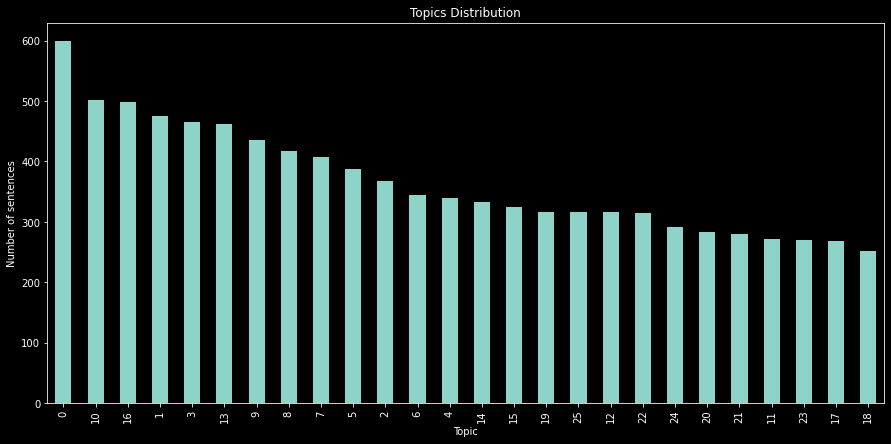

In [75]:
df_dominant_topic.Dominant_Topic.value_counts().plot(kind= 'bar',title='Topics Distribution', xlabel='Topic', ylabel="Number of sentences");

Now can we have a look to the content of the topics. We can even interpret them as follows:

|Topic # | Interpretation | Personal insight |
|---|---|---|
|0| Location to town | Hotel is far away from town, if people didn't arrive by car (some rooms have garage), buying groceries to use the kitchen gets complicated |
|1| Penhouse/ Villa upgrades | The resort is more like a neighborhood, with different apartment buildings, all quite different |
|2| Maintenance problems | |
|3| Good space | Because the rooms are actually aparments they can be quite spacious |
|4| Swimming pool | There is a main large pool in the resort, but also the villas have their private pools |
|5| Beach | The Hotel has direct access to the beach |
|6| Other people's comments | Expectations is quite important |
|7| Service Quality | |
|8| Overall stay and recommendation | It's a common way to start a comment |
|9| Family |  During school holidays the place is packed with families and kids, couples or solo travelers may find it annoying |
|10| Restaurant | |
|11| Surrounding atractions | Daintree and Coral Barrier Reef |
|12| Hotel Atmosphere | Elegant, Tropical and beatiful gardens |
|13| Stay length | typical stays are for the weekend, for a weeding and for school holidays |
|14| Private rooftop | The hotel is composed of several aparment building. Those in the upper level have private rooftop with BBQ adn Jacuzzi |
|15| Breakfast price | There is diversity of pay options regarding the buffet breakfast |
|16| Front desk and Staff | |
|17| Area impressions for rooftop and housekeeping ||
|18| First impressions and internet | Mixed topic. Wifi and online booking. Interestintly, some rooms are privatly owned and managed. Normally booked in AirBnB without including some of the resort's services as housekeeping Some people realise of these upon arrival|
|19| Early Checking and rooms not ready | |
|20| Pool Bar | In the middle of the lagoon pool there is a pool bar |
|21| Food orders and rooms service | |
|22| Self-contained kitchen |  |
|23| Studio room & bedsize arrangements | |
|24| Mixed topics | Other stuff, such as garages |
|25| Accord members benefits | The hotel belongs to the Accor hotels |


### Topic throught time

In [124]:
df_dominant_topic['date'] = data_sentence.date2
topic_time = df_dominant_topic.set_index(pd.DatetimeIndex(df_dominant_topic['date']))
topic_time = topic_time.sort_index()

topic_time = pd.crosstab(topic_time.date, topic_time.Dominant_Topic)
topic_time = topic_time.resample(rule='Y').sum()

Topics shown similar distribution over years

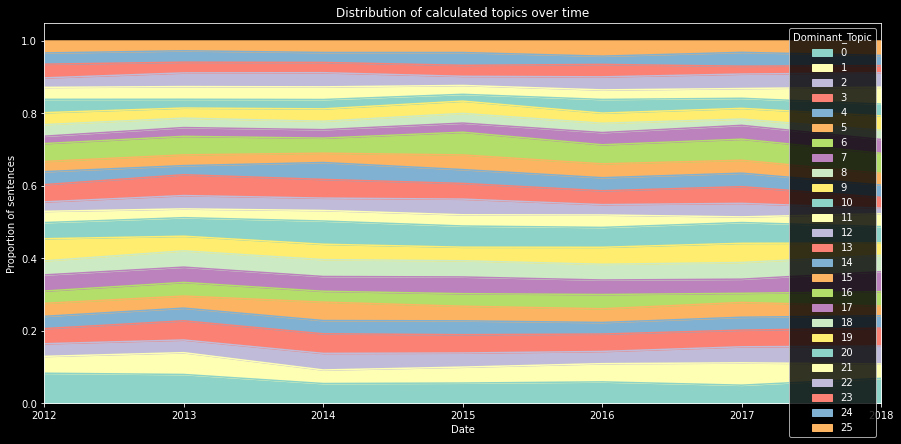

In [211]:
topic_time['total'] = topic_time.sum(axis=1)
topic_time = topic_time.div(topic_time.total,0)
topic_time = topic_time.drop('total',axis=1);
topic_time.loc['2012':].plot(kind = 'area', title = 'Distribution of calculated topics over time', ylabel = 'Proportion of sentences', xlabel = 'Date');

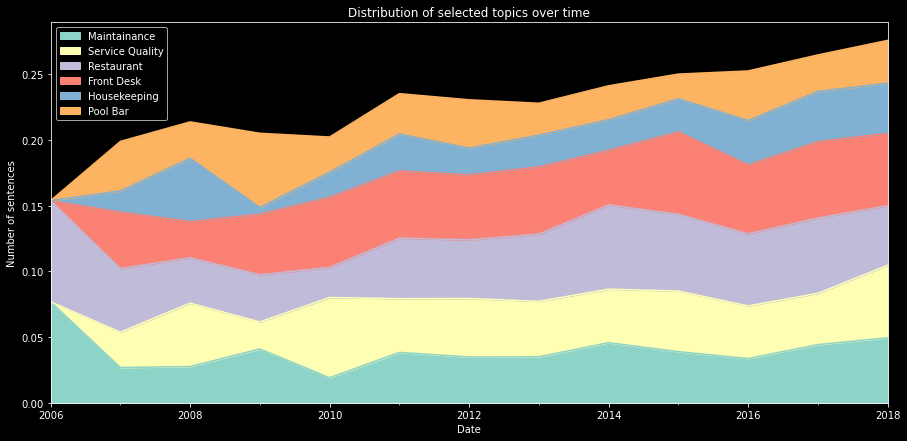

In [210]:
selected_topics = topic_time[[2,7,10,16,17,20]]
selected_topics.columns = ['Maintainance', 'Service Quality', 'Restaurant','Front Desk','Housekeeping','Pool Bar']
selected_topics.plot(kind = 'area', title = 'Distribution of selected topics over time', ylabel = 'Number of sentences', xlabel = 'Date');

# Sentiment analysis

So far I have seen how frequently each section got named, but I don't have idea if it is positive or negative. As most reviews give a high score to the resort we could asumme that most comments are positive, but its not necessary. To do these we could use pre-build polarity sentiment models.

In [94]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def nltk_sentiment(sentence):
    """
    Wrapper to extract polarity sentiment of a sentence
    """
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [128]:
nltk_results = data_sentence.sentence.apply(nltk_sentiment)
results_df = pd.DataFrame(nltk_results.tolist())
#text_df = pd.DataFrame(dataset, columns = ['text'])
data_sentiment = data_sentence.join(results_df)

data_sentiment.set_index(pd.DatetimeIndex(data_sentiment['date2']), inplace=True)
data_sentiment = data_sentiment.sort_index()

### Global sentiment by category

We can check the sentiment score distribution by topic, but given we are aggregating by the enriere period the distributions may look similar. Now, all topics are skewed toward more positive (high score), specially Front Desk, while "something else" is very neutral.

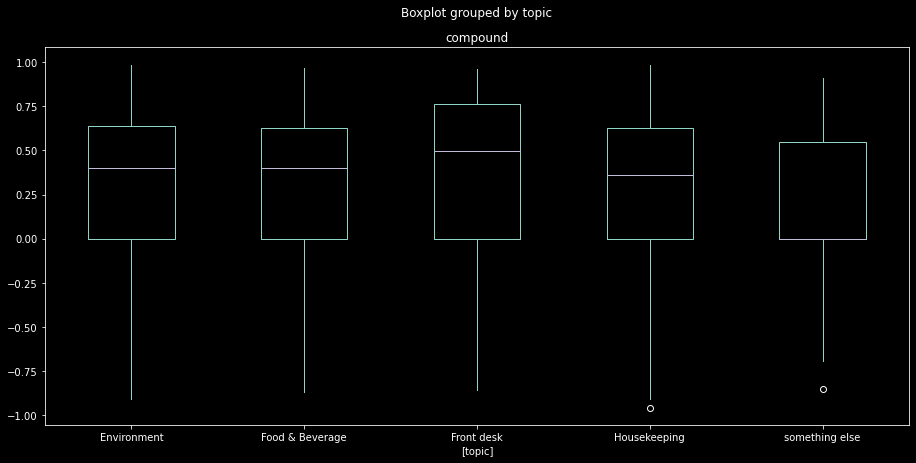

In [129]:
data_sentiment[['topic', 'compound']].boxplot(by='topic',grid=False);

When checking the lda created topics, I noticed that even maintenance problems have a relative median score very positive. In my experience that makes sense because a problem not necessarily can ruin someone’s experience as long is solved propely.

In [148]:
data_sentiment['lda_topic'] = df_dominant_topic.Dominant_Topic.tolist()
data_sentiment[['lda_topic', 'compound']].boxplot(by='lda_topic',grid=False);
topics_names = ['Location to town','Penhouse/ Villa upgrades','Maintenance problems','Good space',
'Swimming pool','Beach','Other peoples comments','Service Quality','Overall stay and recommendation','Family',
'Restaurant','Surrounding atractions','Hotel Atmosphere','Stay length','Private rooftop','Breakfast price','Front desk and Staff',
'Area impressions for rooftop and housekeeping','First impressions and internet','Early Checking and rooms not ready',
'Pool Bar','Food orders and rooms service','Self-contained kitchen','Studio room & bedsize arrangements','Mixed topics','Accord members benefits']
topics_names = {v: k for v, k in enumerate(topics_names)}
data_sentiment['lda_topic_name'] = data_sentiment.lda_topic.map(topics_names)

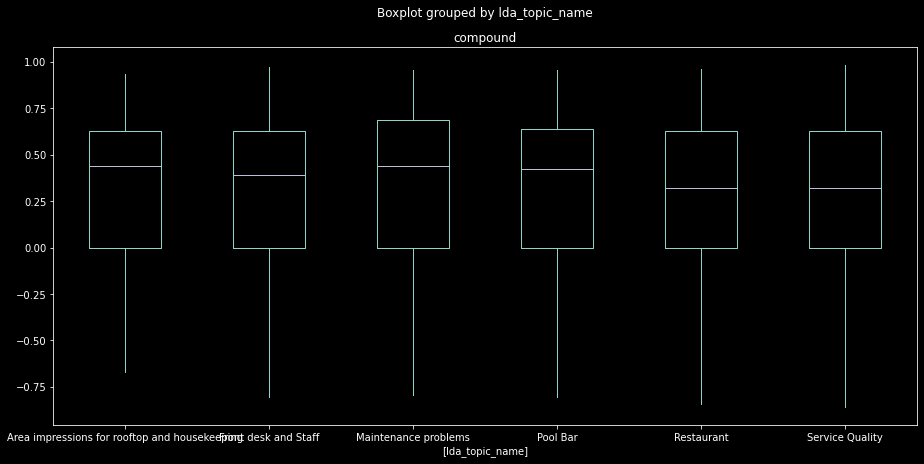

In [160]:
data_sentiment[data_sentiment.lda_topic.isin([2,7,10,16,17,20])][['lda_topic_name', 'compound']].boxplot(by='lda_topic_name',grid=False);

### Sentiment Validation

we can try to validate these results by comparing them to the scores given by the user next to the comments.

In [171]:
data_sentiment.groupby(['topic'])['score','compound'].mean()

C:\Users\framo\AppData\Local\Temp/ipykernel_1124/1927309552.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_sentiment.groupby(['topic'])['score','compound'].mean()


,score,compound
topic,,
Environment,4.219007,0.316039
Food & Beverage,4.231322,0.305624
Front desk,4.197755,0.407254
Housekeeping,4.119543,0.277042
something else,4.294898,0.228765


Now, user score is per comment while sentiment score ('compound') was calculated by sentence. We can group measures and see how correlates. Also we can check how it correlates if we pass the entire text to the sentiment algorithm.

In [204]:
comment_granularity = data_sentiment.groupby(['comment'], as_index=False)['score','compound'].mean()
results = comment_granularity.comment.apply(nltk_sentiment)
comment_granularity['all_text_sentiment'] = pd.DataFrame(results.tolist())['compound']

C:\Users\framo\AppData\Local\Temp/ipykernel_1124/3037956475.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  comment_granularity = data_sentiment.groupby(['comment'], as_index=False)['score','compound'].mean()


In [205]:
comment_granularity.groupby('score').all_text_sentiment.mean()

score
1.0   -0.219062
2.0    0.050132
3.0    0.436775
4.0    0.748154
5.0    0.819334
Name: all_text_sentiment, dtype: float64

<AxesSubplot:xlabel='score', ylabel='compound'>

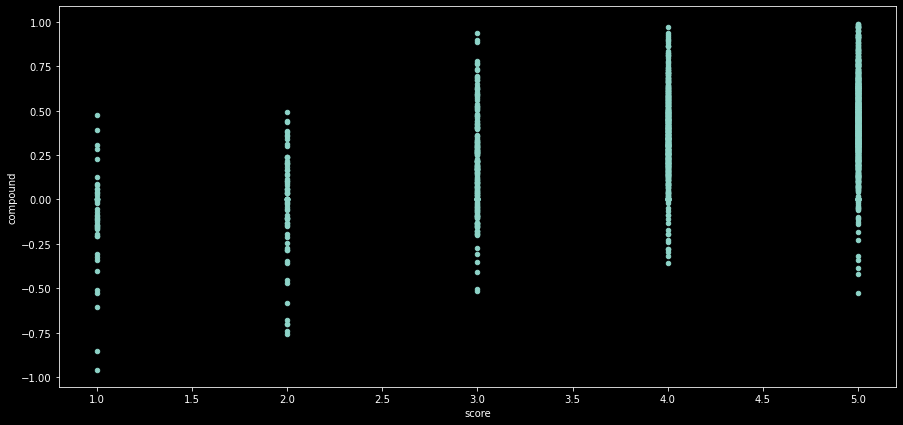

In [206]:
comment_granularity.plot.scatter(x='score', y='compound')

In [207]:
comment_granularity.corr()

,score,compound,all_text_sentiment
score,1.000000,0.483983,0.498958
compound,0.483983,1.000000,0.719776
all_text_sentiment,0.498958,0.719776,1.000000


Effectibly, there is a great correlation score ( 0.72) between the mean sentiment score  for all phases in a comment and the user score for that comment. 

### Sentiment by time and category

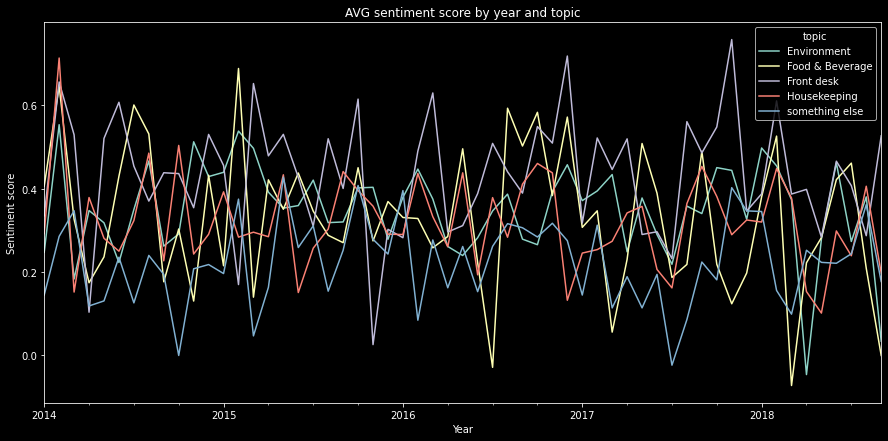

In [163]:
sen = pd.pivot_table(data_sentiment, values='compound', index=data_sentiment.index, columns=['topic'], aggfunc=np.mean)
sen = sen.resample(rule='M').mean()
sen[sen.index>pd.to_datetime("31/12/2013", format= "%d/%m/%Y")].plot(kind='line', title='AVG sentiment score by year and topic', xlabel='Year', ylabel='Sentiment score');

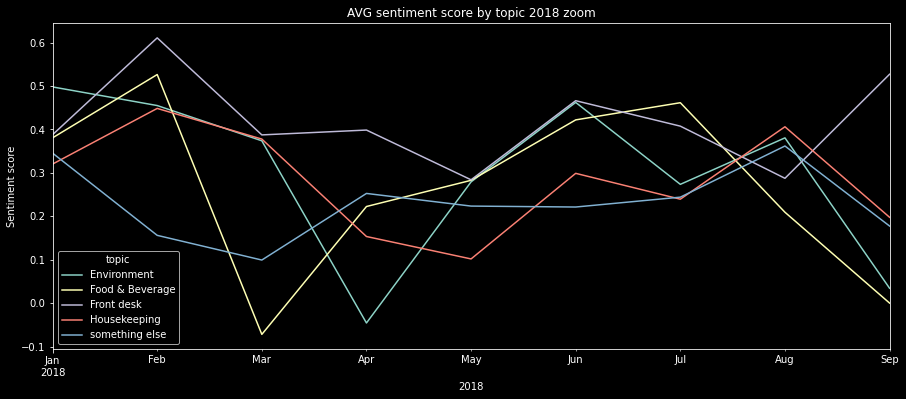

In [164]:
sen.loc['2018':'2018',:].plot(kind='line', figsize=(15,6), title='AVG sentiment score by topic 2018 zoom', xlabel='2018', ylabel='Sentiment score');

Positive sentiments are more likely for every aspect but the most important takeaway here is variation. Both graphs show a lot of noise. Let's clear it out a bit.

### Seasonal Decomposition

By treating the sentiment score evolution as a signal we can apply signal decomposition to see throught the noise.

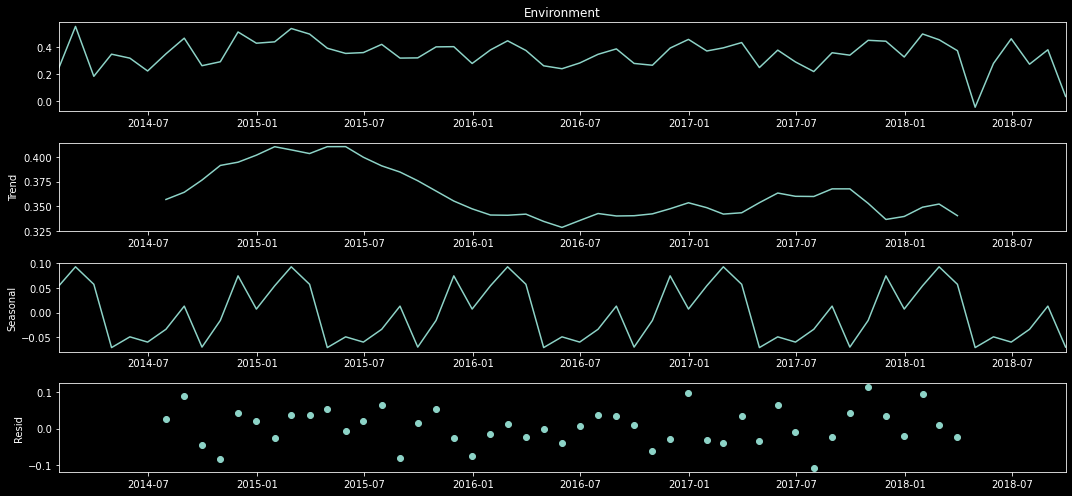

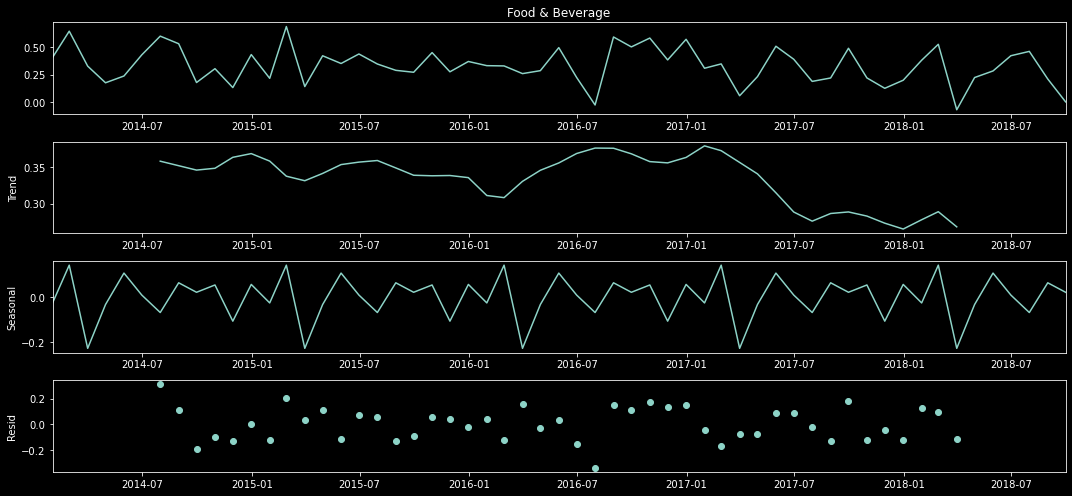

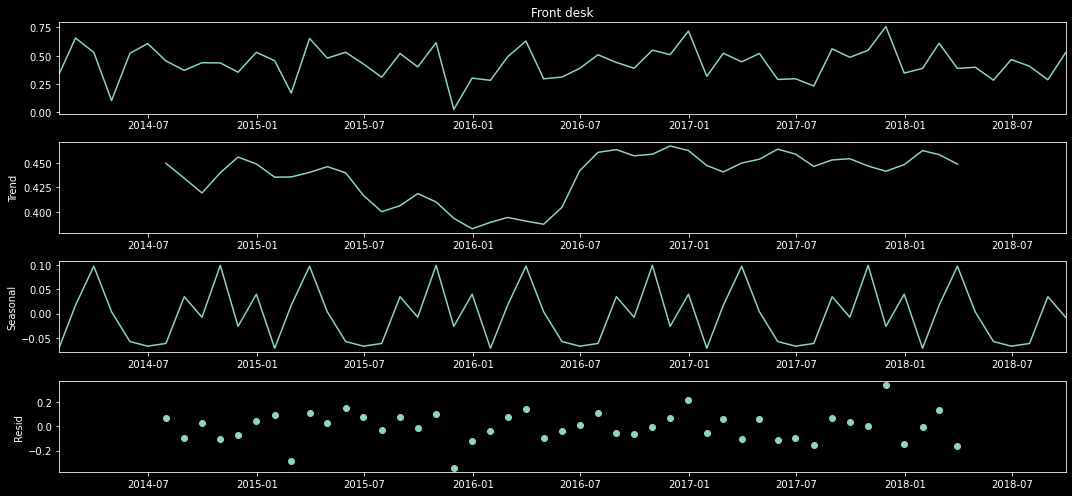

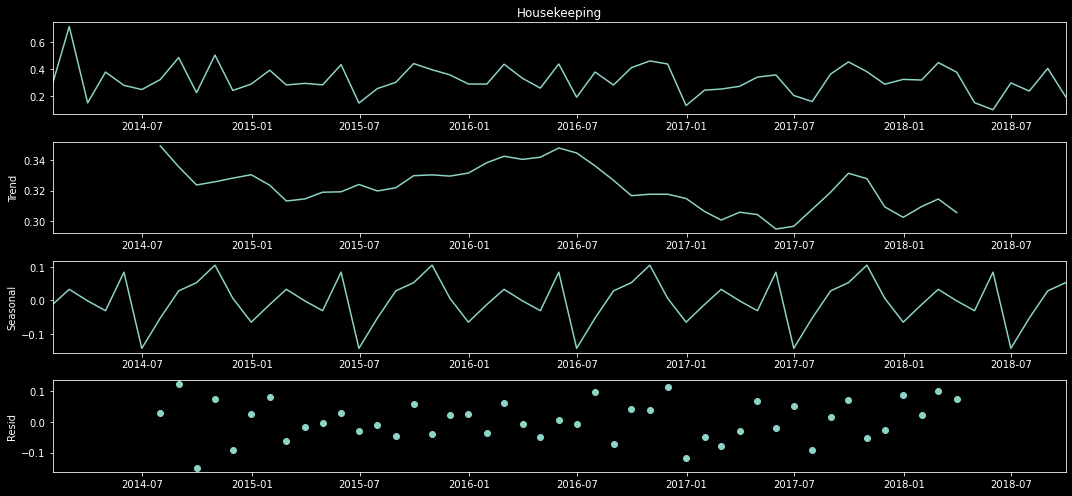

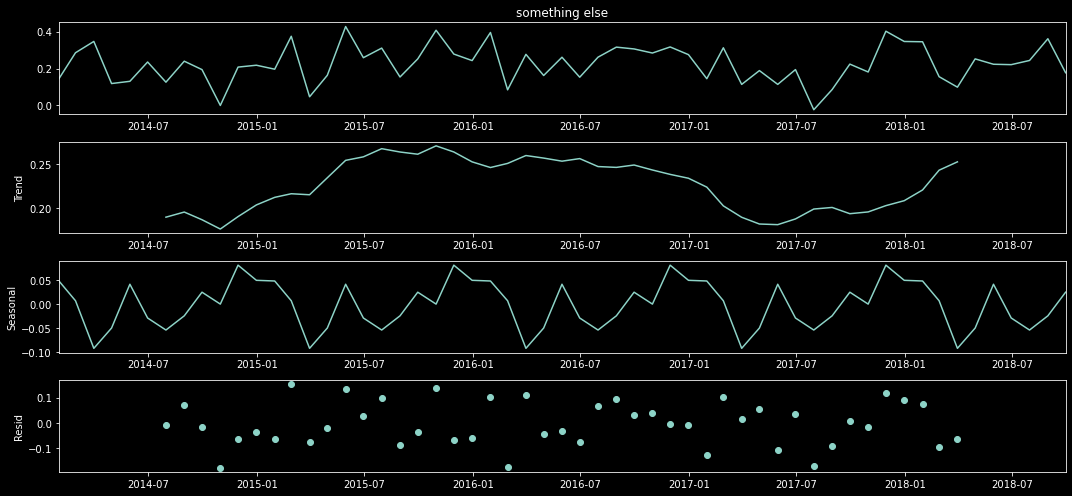

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose
serie = sen[sen.index>pd.to_datetime("31/12/2013", format= "%d/%m/%Y")]
for i in sen.columns:
    result = seasonal_decompose(serie[i], model='additive')
    result.plot()


- Environment score has a negative trend. Are the buildings getting old? Also, there is a strong seasonality around the end and beginning of the year.
- Food & beverage shows a declining trend in recent years and a seasonal low score during off-peak periods, maybe due to personal rotations?
- Front desk showed a very stable trend after 2016. Although, we don't even need to decompose the signal to see the seasonal pattern in its behaviour. Again, there are two patterns, before and after 2016
- Housekeeping is something that is really affected by seasonality. Around mid-year is every time the lowest score in the year. Which matches the high peak periods.

OK, this looks interesting. Sentiments are seasonal and overall, don’t show a trend. Except for "Environment," which is becoming more and more negative. It kind of makes sense that the Environment get a lower score over time as the infrastructure becomes old and regular customers get used to, for instance, the pool. It doesn't play an important part in their experience anymore.

On the other hand, housekeeping is very seasonal (very positive at the beginning of the year, flat the rest of the year).

## Final comments

We can summarise the main takeaway as:

Time series:
- Comments are generally positive, although, in the last year there are fewer positive comments while negatives remained the same

Topics:
- The distance to town is the most common topic, and it has deep implications for the experience
- For the after-mention reason the guest has the option of using the kitchen (which also requires going to the town) or the resort restaurant
- The front desk staff is another commented topic
- Also, the hotel configuration and the different types of rooms and buildings. Customers see advantageous to be changed (upgraded) according to different preferences
- Clean and spacious rooms are another important topic
- It is mostly a Family oriented place, which is good and bad for some people
- The main swimming Pool is the great attractive!
- Beach is just nearby
- Atmosphere: luxury and tropical

Sentiments:
- Front desk is the most positive sentiment experience
- Housekeeping is lowest sentiment experience

Seasonality:
- Seasonality creates pressure over both Food and Beverage and Housekeeping.
- It is important to consider that one of the most important features of the PPD is the swimming pool and other environmental and infrastructure factors, and those may need renewal as novelty and use decay over time.
- Because rooms are functional apartments with independent access, some rooms are privately owned and rented through other media such AirBnB. And those may not include services from the hotel management and may have separate housekeeping and other services. Those can impact the comments score as more and more rooms are being sold to private owners.

There are more things that can be done with this dataset:
- We could go deeper with the topics and try to identify subtopics and cross with other variables Or
- Create a regression to identify factors affecting the overall score Or
- Filter only negative comments or sentences and recalculate topics to identify key areas to improve
- Look into the customer demographics. Locals vs other states or international may have very different experiences.
